In [69]:
import numpy as np
import matplotlib.pyplot as plt
from utils import misc
import pandas as pd
from utils import misc


There are 4 types of volatility:
- Actual
- Historical
- Implied
- Forward

Actual volatility is the instantaneous number that goes into generate the stock returns. We assume that this number exists, but can never measure it.

Historical or realised volatility is the volatility (usually standard deviation) measured over some historical period.

Implied volatility is the volatility value arrived by applying the black-scholes model in reverse to market prices of various options.

Forward or forecasted volatility is the estimate of volatility over some future period.

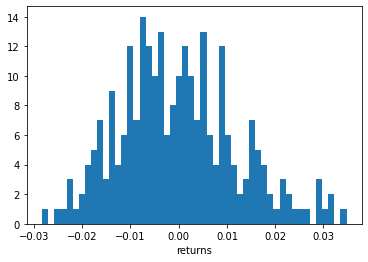

simulation vol:         0.012598815766974242
historical vol:         0.012194232504005415


In [70]:
drift = 0
vol = 0.2
init_price = 100
num_steps = 252
step_size = 1 / 252

price_series = misc.generate_stochastic_stock_price(drift, vol, init_price, num_steps, step_size)

price_dict = {'price': price_series}
df = pd.DataFrame.from_dict(price_dict)
df['returns'] = df['price'].pct_change(1)

plt.hist(df['returns'], bins=50)
plt.xlabel('returns')
plt.show()


print(f'simulation vol:         {vol * np.sqrt(step_size)}')
print(f'historical vol:         {df["returns"].std()}')

We can forecast future vol by using the realised vol of the past 30 days.

If we believe that volatility is constant or slowly varying and we have stock returns over $n$ days:
\begin{equation}
    \sigma ^ 2 = \frac{1}{N}\sum^{N}_{i = 1} R_i^2
\end{equation}
where $R_i = \frac{S_i - S_{i-1}}{S_{i-1}}$.

This calculation results in similar values as the normal standard deviation calculations.

average realised vol:   0.012012319407199388


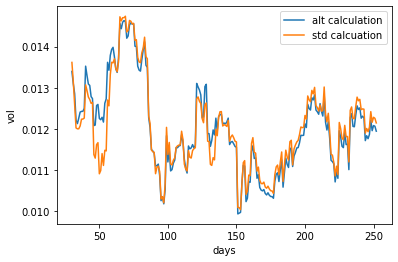

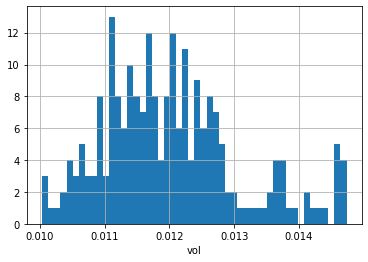

In [71]:
df['30_real_vol'] = df['returns'].rolling(30).std()

print(f'average realised vol:   {df["30_real_vol"].mean()}')

df['ret2'] = df['returns'] * df['returns']
df['30_real_vol_alt'] = np.sqrt(df['ret2'].rolling(30).sum() / 30)


plt.plot(df['30_real_vol_alt'], label='alt calculation')
df['30_real_vol'].plot(label='std calcuation')
plt.xlabel('days')
plt.ylabel('vol')
plt.legend()
plt.show()

df['30_real_vol'].hist(bins=50)
plt.xlabel('vol')
plt.show()

Consider the case where there is 1 day of extremely large return. This is unlikely but possible, even if the underlying distribution of daily returns remains the same.

Ideally, this should not result in a significant change in realised vol.

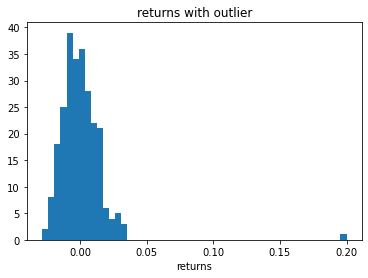

In [72]:
# assume there is a random 20% daily return on day 100
df['returns_out'] = df['returns']
df.loc[100, 'returns_out'] = 0.2
plt.hist(df['returns_out'], bins=50)
plt.xlabel('returns')
plt.title('returns with outlier')
plt.show()

simulation vol:       0.012598815766974242
average realised vol: 0.015533242663943729


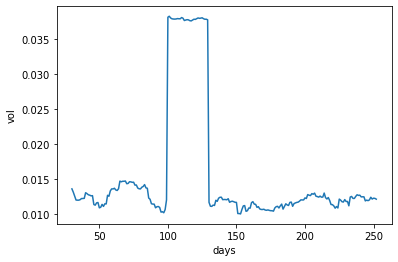

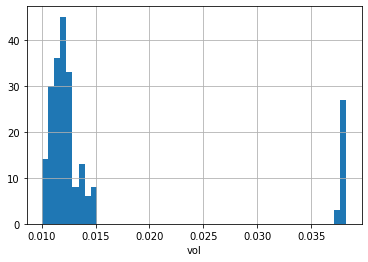

In [73]:
# recalculate realised vol with outlier

df['30_real_vol_out'] = df['returns_out'].rolling(30).std()

print(f'simulation vol:       {vol * np.sqrt(step_size)}')
print(f'average realised vol: {df["30_real_vol_out"].mean()}')

df['30_real_vol_out'].plot()
plt.xlabel('days')
plt.ylabel('vol')
plt.show()

df['30_real_vol_out'].hist(bins=50)
plt.xlabel('vol')
plt.show()

We note that the 30 day rolling realised vol is elevated at day 100 to 130 until the outlier day falls out of sample. This should not be the case, since the outlier day can be drawn from the same distribution, despite being an unlikely move.

Instead of taking the 30 day realised vol as an estimate of future vol, we may believe that future vol varies about some long term average $\bar{\sigma}$.

\begin{equation}
    \sigma_n^2 = \alpha \bar{\sigma}^2 + (1-\alpha)\frac{1}{n}\sum_{i=1}^{n}R_i^2
\end{equation}

This is the ARCH model.

Historical vol: 0.012194232504005411


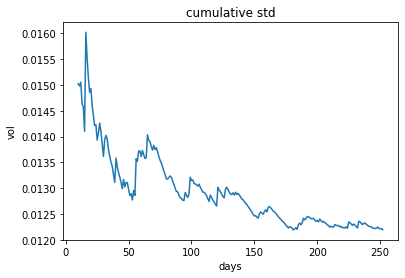

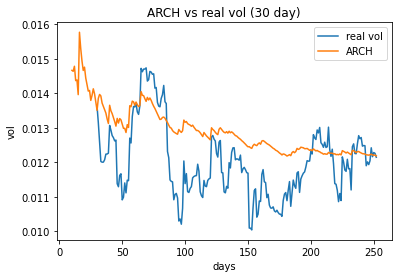

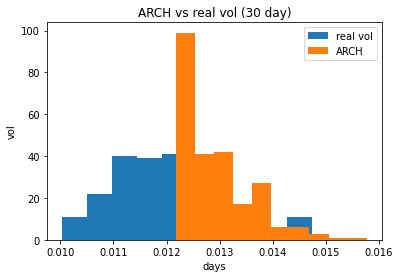

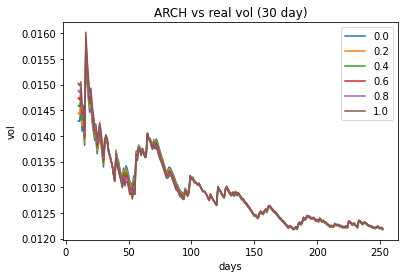

In [93]:
# use cumulative std as measure of average historical vol at some point in time
df['cum_std'] = df['returns'].expanding(10).std()

# check that calculation is correct
print(f'Historical vol: {df["cum_std"].to_numpy()[-1]}')

# plot cumulative std
df['cum_std'].plot()
plt.xlabel('days')
plt.ylabel('vol')
plt.title('cumulative std')
plt.show()

alpha = 0.5

df['arch'] = np.sqrt(alpha * df['cum_std']**2 + (1 - alpha) * df['ret2'].expanding().mean())

# plot ARCH vs 30 day realised vol
plt.plot(df['30_real_vol'], label='real vol')
plt.plot(df['arch'], label='ARCH')
plt.legend()
plt.xlabel('days')
plt.ylabel('vol')
plt.title('ARCH vs real vol (30 day)')
plt.show()

# plot histogram of ARCH vs 30 day realised vol
plt.hist(df['30_real_vol'], label='real vol')
plt.hist(df['arch'], label='ARCH')
plt.legend()
plt.xlabel('days')
plt.ylabel('vol')
plt.title('ARCH vs real vol (30 day)')
plt.show()

# plot different values of alpha

for i in range(0, 11, 2):
    alpha = i / 10
    arch = np.sqrt(alpha * df['cum_std'] * df['cum_std'] + (1 - alpha) * df['ret2'].expanding().mean())

    plt.plot(arch, label=str(alpha))
plt.legend()
plt.xlabel('days')
plt.ylabel('vol')
plt.title('ARCH vs real vol (30 day)')
plt.show()

If we use the returns with outlier:

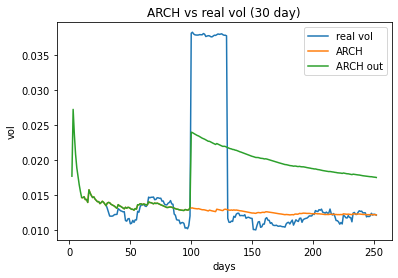

In [97]:
alpha = 0.5
df['ret2_out'] = df['returns_out'] * df['returns_out']
df['cum_std_out'] = df['returns_out'].expanding().std()
df['arch_out'] = np.sqrt(alpha * df['cum_std_out']**2 + (1 - alpha) * df['ret2_out'].expanding().mean())

# plot ARCH vs 30 day realised vol
plt.plot(df['30_real_vol_out'], label='real vol')
plt.plot(df['arch'], label='ARCH')
plt.plot(df['arch_out'], label='ARCH out')
plt.legend()
plt.xlabel('days')
plt.ylabel('vol')
plt.title('ARCH vs real vol (30 day)')
plt.show()

We can also use a exponential moving average of the volatility.

\begin{equation}
    \sigma_n^2 = (1-\lambda)\sum_{i=1}^{\infty} \lambda^{i-1} R_{n-i+1}^2 
\end{equation}

We can simplify the expression as:
\begin{equation}
    \sigma_n^2 = \lambda \sigma_{n-1}^2 + (1-\lambda)R_n^2
\end{equation}

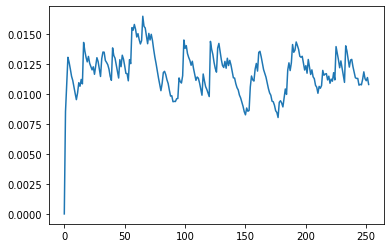

In [89]:
lambda_ = 0.9
ema_vol = 0
ema_arr = [ema_vol]
for i in range(1, len(df)):
    ema_vol = np.sqrt(ema_vol * ema_vol * lambda_ + (1 - lambda_) * df['ret2'][i])
    ema_arr.append(ema_vol)
df['ema_vol'] = ema_arr

plt.plot(df['ema_vol'])